In [ ]:
import torch
import torch.nn as nn

import pandas
import matplotlib.pyplot as plt
import random
import numpy as np

In [ ]:
# def generate_real():
#   real_data=torch.FloatTensor([1,0,1,0])
#   return real_data


# 실제 세계의  데이터는 정확히 딱 떨어지는 값일 확률이 거의 없기 때문에, 약간의 임의성을 추가해줌
def generate_real():
  real_data=torch.FloatTensor(
      [random.uniform(0.8,1.0), # 0.8과 1.0 사이의 임의의 값
       random.uniform(0.0,0.2), # 0.0과 0.2 사이의 임의의 값
       random.uniform(0.8,1.0),
       random.uniform(0.0,0.2)]
  )
  return real_data



In [ ]:
generate_real()

tensor([0.8650, 0.0814, 0.8670, 0.0351])

판별기 만들기

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.model=nn.Sequential(
        nn.Linear(4,3),
        nn.Sigmoid(),
        nn.Linear(3,1),
        nn.Sigmoid()
    )

    # 손실함수 설정
    self.loss_function=nn.MSELoss()

    # SGD 옵티마이저 설정
    self.optimizer=torch.optim.SGD(self.parameters(),lr=0.01)

    # 진행 측정을 위한 변수 초기화
    self.counter=0
    self.progress=[]

    pass

  def forward(self,inputs):
    return self.model(inputs)

  def train(self,inputs,targets):
    outputs=self.forward(inputs)

    loss=self.loss_function(outputs,targets)


    self.counter+=1
    if (self.counter%10 ==0):
      self.progress.append(loss.item())
      pass

    if(self.counter % 10000==0):
      print('counter =',self.counter)
      pass

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    pass


  def plot_progress(self):
    df=pandas.DataFrame(self.progress,columns=['loss'])
    df.plot(ylim=(0,1.0),figsize=(16,8),alpha=0.1,marker='.',grid=True,yticks=(0,0.25,0.5))
    pass

판별기 test

In [ ]:
# 임의의 노이즈
def generate_random(size):
  random_data=torch.rand(size)
  return random_data

In [ ]:
D=Discriminator()

for i in range(10000):
  D.train(generate_real(),torch.FloatTensor([1.0]))
  D.train(generate_random(4),torch.FloatTensor([0.0]))
  pass

counter = 10000
counter = 20000


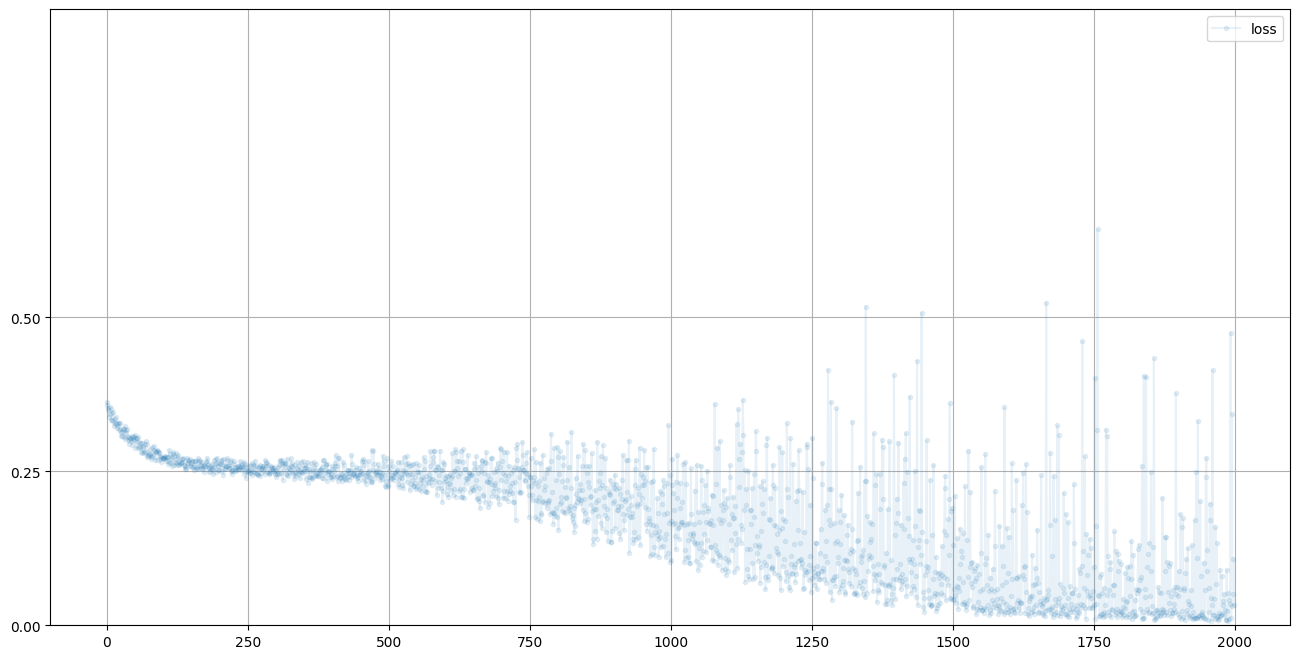

In [ ]:
D.plot_progress()

In [ ]:
print(D.forward(generate_real() ).item())
print(D.forward(generate_random(4) ).item())

0.7968423366546631
0.1250046342611313


생성기 만들기

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    self.model=nn.Sequential(
        nn.Linear(1,3),
        nn.Sigmoid(),
        nn.Linear(3,4),
        nn.Sigmoid()
    )

    # 손실함수 x

    # SGD 옵티마이저 설정
    self.optimizer=torch.optim.SGD(self.parameters(),lr=0.01)

    # 진행 측정을 위한 변수 초기화
    self.counter=0
    self.progress=[]

    pass

  def forward(self,inputs):
    return self.model(inputs)

  def train(self,D,inputs,targets):
    g_output=self.forward(inputs)

    d_output=D.forward(g_output)

    loss=D.loss_function(d_output, targets)

    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter+=1
    if (self.counter%10 ==0):
      self.progress.append(loss.item())
      pass

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    pass


  def plot_progress(self):
    df=pandas.DataFrame(self.progress,columns=['loss'])
    df.plot(ylim=(0,1.0),figsize=(16,8),alpha=0.1,marker='.',grid=True,yticks=(0,0.25,0.5))
    pass

In [ ]:
G=Generator()
G.forward(torch.FloatTensor([0.5]))

tensor([0.5899, 0.5702, 0.3581, 0.5770], grad_fn=<SigmoidBackward0>)

GAN 훈련하기

In [ ]:
%%time

D=Discriminator()

G=Generator()

image_list=[]

for i in range( 10000 ):

  #참에 대한 판별기 훈련
  D.train(generate_real(), torch.FloatTensor([1.0]))
  # 거짓에 대한 판별기 훈련
  D.train(G.forward(torch.FloatTensor([0.5])).detach(),torch.FloatTensor([0.0]))
  G.train(D, torch.FloatTensor([0.5]),torch.FloatTensor([1.0]))


  if ( i % 1000==0 ):
    image_list.append(G.forward(torch.FloatTensor([0.5])).detach().numpy())

  pass

counter = 10000
counter = 20000
CPU times: user 24.4 s, sys: 388 ms, total: 24.8 s
Wall time: 25.2 s


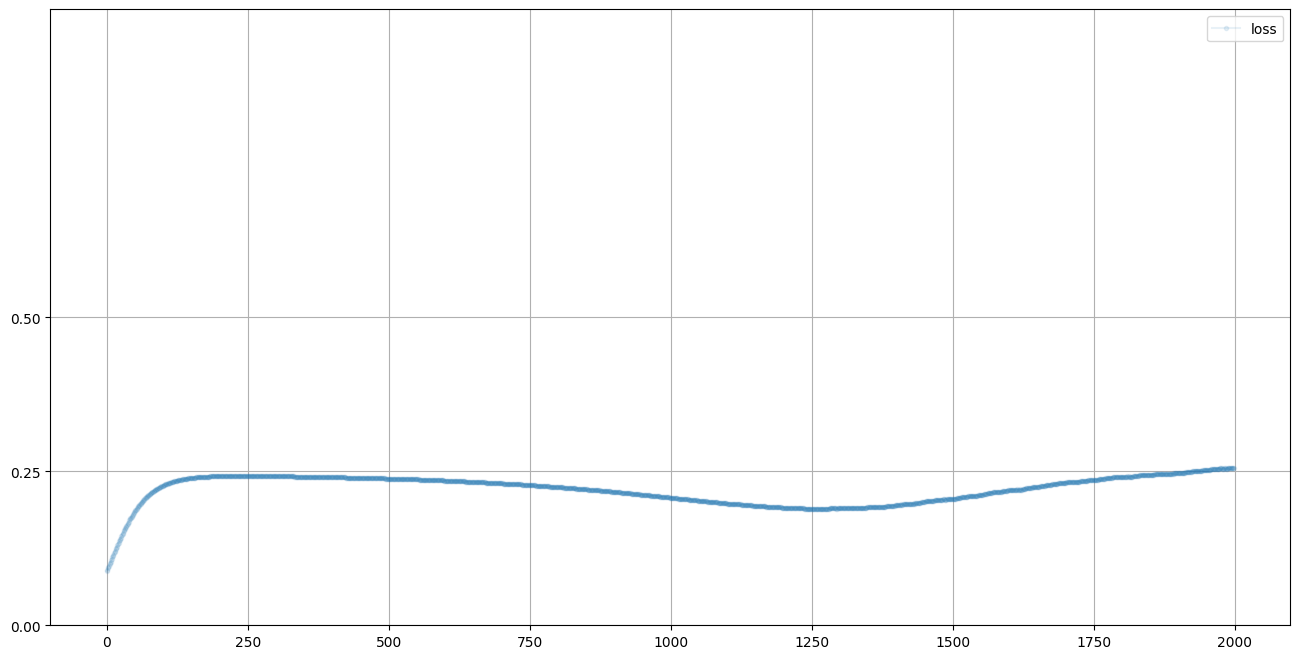

In [ ]:
D.plot_progress()

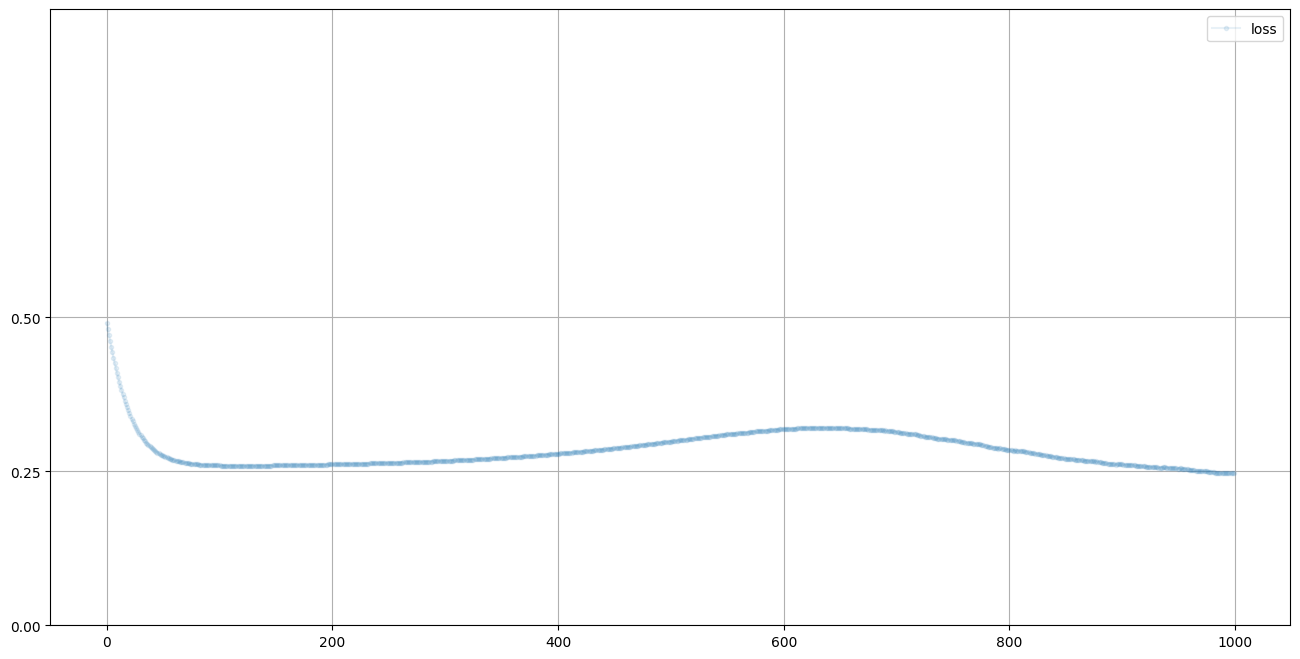

In [ ]:
G.plot_progress()

In [ ]:
G.forward(torch.FloatTensor([0.5]))

tensor([0.8722, 0.0775, 0.9098, 0.0869], grad_fn=<SigmoidBackward0>)

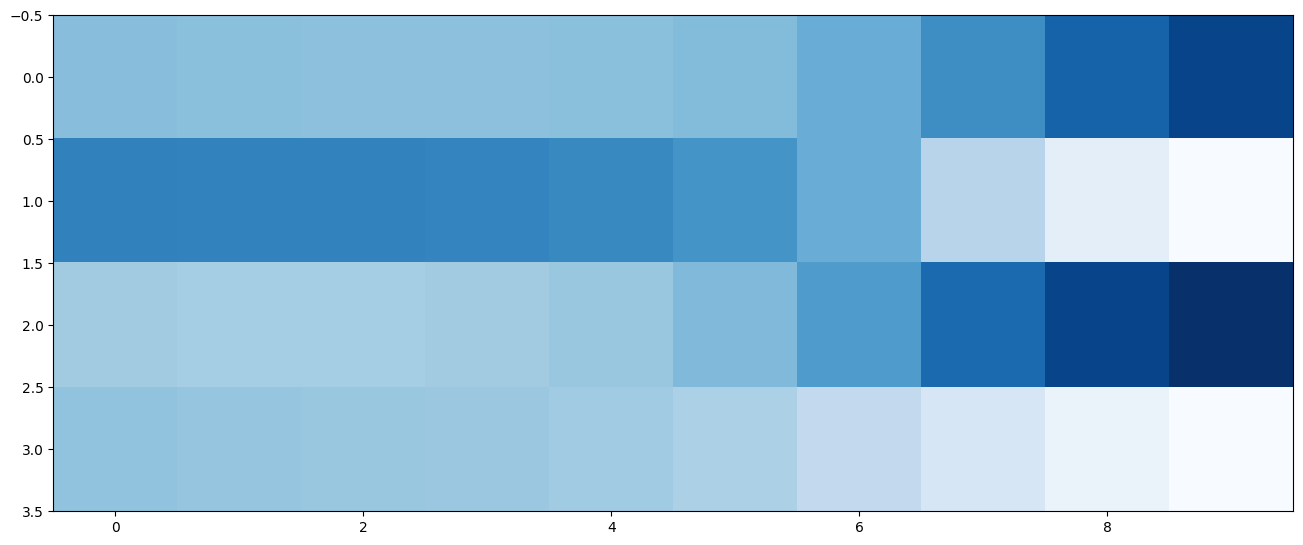

In [ ]:
plt.figure(figsize=(16,8))
plt.imshow(np.array(image_list).T , interpolation='none',cmap="Blues")